In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import AxesGrid
import pandas as pd
import xarray as xr
import copy
import datetime as dt
import calendar
import seaborn as sns
import regionmask
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib as mpl

In [3]:
def covariance(x,y,dim=None):
    return xr.dot(x-x.mean(dim), y-y.mean(dim), dims=dim) / x.count(dim)


def correlation(x,y,dim=None):
    return covariance(x,y,dim) / (x.std(dim) * y.std(dim))

def xr_trends(xarray):
    """ Calcula la tendencia
    lineal de un xarray en el tiempo"""
    vals = xarray.values
    years = xarray.time.dt.year.values
    # Reshape to an array with as many rows as years and as many columns as there are pixels
    vals2 = vals.reshape(len(years), -1)
    # Do a first-degree polyfit
    regressions = np.polyfit(years, vals2, 1)
    # Get the coefficients back
    trends = regressions[0,:].reshape(vals.shape[1], vals.shape[2])
    da_trends = xr.DataArray(trends, coords={'lat': xarray.lat,
                                             'lon': xarray.lon},
                            dims=['lat', 'lon'])
    return da_trends

In [4]:
# Load files CMIP5

pr_c5_hist = xr.open_mfdataset('NorESM1-M/pr_Amon_NorESM1-M_historical_r*i1p1_197601-200512_2.5_anu.nc',
                              combine='nested',
                              concat_dim='r')['pr']
pr_c5_ens = pr_c5_hist.mean(dim='r', keep_attrs=True)
pr_c5_26_close = xr.open_dataset('NorESM1-M/pr_Amon_NorESM1-M_rcp26_r1i1p1_202001-204912_2.5_anu.nc'
                                )['pr']
pr_c5_26_far = xr.open_dataset('NorESM1-M/pr_Amon_NorESM1-M_rcp26_r1i1p1_207001-209912_2.5_anu.nc'
                                )['pr']
pr_c5_85_close = xr.open_dataset('NorESM1-M/pr_Amon_NorESM1-M_rcp85_r1i1p1_202001-204912_2.5_anu.nc'
                                )['pr']
pr_c5_85_far = xr.open_dataset('NorESM1-M/pr_Amon_NorESM1-M_rcp85_r1i1p1_207001-209912_2.5_anu.nc'
                                )['pr']

# """"""""""""""""""""""""""""""""""""""""""
ev_c5_hist = xr.open_mfdataset('NorESM1-M/evspsbl_Amon_NorESM1-M_historical_r*i1p1_197601-200512_2.5_anu.nc',
                               combine='nested',
                               concat_dim='r')['evspsbl']
ev_c5_ens = ev_c5_hist.mean(dim='r', keep_attrs=True)
ev_c5_26_close = xr.open_dataset('NorESM1-M/evspsbl_Amon_NorESM1-M_rcp26_r1i1p1_202001-204912_2.5_anu.nc'
                                )['evspsbl']
ev_c5_26_far   = xr.open_dataset('NorESM1-M/evspsbl_Amon_NorESM1-M_rcp26_r1i1p1_207001-209912_2.5_anu.nc'
                                )['evspsbl']
ev_c5_85_close = xr.open_dataset('NorESM1-M/evspsbl_Amon_NorESM1-M_rcp85_r1i1p1_202001-204912_2.5_anu.nc'
                                )['evspsbl']
ev_c5_85_far   = xr.open_dataset('NorESM1-M/evspsbl_Amon_NorESM1-M_rcp85_r1i1p1_207001-209912_2.5_anu.nc'
                                )['evspsbl']
# """"""""""""""""""""""""""""""""""""""""""
ep_c5_hist = xr.open_mfdataset('NorESM1-M/etp_Amon_NorESM1-M_historical_r*i1p1_197601-200512_2.5_anu.nc',
                               combine='nested',
                               concat_dim='r')['etp']
ep_c5_ens = ep_c5_hist.mean(dim='r', keep_attrs=True)
ep_c5_26_close = xr.open_dataset('NorESM1-M/etp_Amon_NorESM1-M_rcp26_r1i1p1_202001-204912_2.5_anu.nc'
                                )['etp']
ep_c5_26_far   = xr.open_dataset('NorESM1-M/etp_Amon_NorESM1-M_rcp26_r1i1p1_207001-209912_2.5_anu.nc'
                                )['etp']
ep_c5_85_close = xr.open_dataset('NorESM1-M/etp_Amon_NorESM1-M_rcp85_r1i1p1_202001-204912_2.5_anu.nc'
                                )['etp']
ep_c5_85_far   = xr.open_dataset('NorESM1-M/etp_Amon_NorESM1-M_rcp85_r1i1p1_207001-209912_2.5_anu.nc'
                                )['etp']
# """"""""""""""""""""""""""""""""""""""""""""

t_c5_hist = xr.open_mfdataset('NorESM1-M/tas_Amon_NorESM1-M_historical_r*i1p1_197601-200512_2.5_anu.nc',
                              combine='nested',
                              concat_dim='r')['tas']
t_c5_ens = t_c5_hist.mean(dim='r', keep_attrs=True)
t_c5_26_close = xr.open_dataset('NorESM1-M/tas_Amon_NorESM1-M_rcp26_r1i1p1_202001-204912_2.5_anu.nc'
                               )['tas']
t_c5_26_far   = xr.open_dataset('NorESM1-M/tas_Amon_NorESM1-M_rcp26_r1i1p1_207001-209912_2.5_anu.nc'
                               )['tas']
t_c5_85_close = xr.open_dataset('NorESM1-M/tas_Amon_NorESM1-M_rcp85_r1i1p1_202001-204912_2.5_anu.nc'
                               )['tas']
t_c5_85_far   = xr.open_dataset('NorESM1-M/tas_Amon_NorESM1-M_rcp85_r1i1p1_207001-209912_2.5_anu.nc'
                               )['tas']
# """"""""""""""""""""""""""""""""""""""
q_c5_hist = xr.open_mfdataset('NorESM1-M/huss_historical_r*_anu.nc',
                            combine='nested',
                            concat_dim='r')['huss']
q_c5_ens = q_c5_hist.mean(dim='r', keep_attrs=True)
q_c5_26_close = xr.open_dataset('NorESM1-M/huss_Amon_NorESM1-M_rcp26_r1_202001-204912_2.5_anu.nc'
                               )['huss']
q_c5_26_far   = xr.open_dataset('NorESM1-M/huss_Amon_NorESM1-M_rcp26_r1_207001-209912_2.5_anu.nc'
                               )['huss']
q_c5_85_close = xr.open_dataset('NorESM1-M/huss_Amon_NorESM1-M_rcp85_r1_202001-204912_2.5_anu.nc'
                               )['huss']
q_c5_85_far   = xr.open_dataset('NorESM1-M/huss_Amon_NorESM1-M_rcp85_r1_207001-209912_2.5_anu.nc'
                               )['huss']

In [5]:
# Load files CMIP6
pr_c6_hist = xr.open_mfdataset('NorESM2-LM/pr_Amon_NorESM2-LM_historical_r*_2.5_anu.nc',
                              combine='nested',
                              concat_dim='r')['pr']
pr_c6_ens = pr_c6_hist.mean(dim='r', keep_attrs=True)
pr_c6_126_close = xr.open_dataset('NorESM2-LM/pr_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5_anu.nc',
                                 )['pr']
pr_c6_126_far   = xr.open_dataset('NorESM2-LM/pr_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5_anu.nc'
                                 )['pr']
pr_c6_585_close = xr.open_dataset('NorESM2-LM/pr_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5_anu.nc'
                                 )['pr']
pr_c6_585_far   = xr.open_dataset('NorESM2-LM/pr_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5_anu.nc'
                                 )['pr']
# """"""""""""""""""""""""""""""""""""""
mes_pr_c6_hist = xr.open_mfdataset('NorESM2-LM/pr_Amon_NorESM2-LM_historical_r*_2.5_mes.nc',
                              combine='nested',
                              concat_dim='r')['pr']
mes_pr_c6_ens = mes_pr_c6_hist.mean(dim='r', keep_attrs=True)
mes_pr_c6_126_close = xr.open_dataset('NorESM2-LM/pr_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5_mes.nc',
                                 )['pr']
mes_pr_c6_126_far   = xr.open_dataset('NorESM2-LM/pr_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5_mes.nc'
                                 )['pr']
mes_pr_c6_585_close = xr.open_dataset('NorESM2-LM/pr_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5_mes.nc'
                                 )['pr']
mes_pr_c6_585_far   = xr.open_dataset('NorESM2-LM/pr_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5_mes.nc'
                                 )['pr']
# """"""""""""""""""""""""""""""""""""""
ev_c6_hist = xr.open_mfdataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_historical_r*_2.5_anu.nc',
                               combine='nested',
                               concat_dim='r')['evspsbl']
ev_c6_ens = ev_c6_hist.mean(dim='r', keep_attrs=True)
ev_c6_126_close = xr.open_dataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5_anu.nc'
                                 )['evspsbl']
ev_c6_126_far   = xr.open_dataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5_anu.nc'
                                 )['evspsbl']
ev_c6_585_close = xr.open_dataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ssp585_r1i1p1f1_gn_2020-2049_2.5_anu.nc'
                                 )['evspsbl']
ev_c6_585_far   = xr.open_dataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ssp585_r1i1p1f1_gn_2070-2099_2.5_anu.nc'
                                 )['evspsbl']
# """"""""""""""""""""""""""""""""""""""
mes_ev_c6_hist = xr.open_mfdataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_historical_r*_2.5_mes.nc',
                               combine='nested',
                               concat_dim='r')['evspsbl']
mes_ev_c6_ens = mes_ev_c6_hist.mean(dim='r', keep_attrs=True)
mes_ev_c6_126_close = xr.open_dataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5_mes.nc'
                                 )['evspsbl']
mes_ev_c6_126_far   = xr.open_dataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5_mes.nc'
                                 )['evspsbl']
mes_ev_c6_585_close = xr.open_dataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ssp585_r1i1p1f1_gn_2020-2049_2.5_mes.nc'
                                 )['evspsbl']
mes_ev_c6_585_far   = xr.open_dataset('NorESM2-LM/evspsbl_Amon_NorESM2-LM_ssp585_r1i1p1f1_gn_2070-2099_2.5_mes.nc'
                                 )['evspsbl']
# """"""""""""""""""""""""""""""""""""""
ep_c6_hist = xr.open_mfdataset('NorESM2-LM/etp_Amon_NorESM2-LM_historical_r*_2.5_anu.nc',
                               combine='nested',
                               concat_dim='r')['etp']
ep_c6_ens = ep_c6_hist.mean(dim='r', keep_attrs=True)
ep_c6_126_close = xr.open_dataset('NorESM2-LM/etp_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5_anu.nc'
                                 )['etp']
ep_c6_126_far   = xr.open_dataset('NorESM2-LM/etp_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5_anu.nc'
                                 )['etp']
ep_c6_585_close = xr.open_dataset('NorESM2-LM/etp_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5_anu.nc'
                                 )['etp']
ep_c6_585_far   = xr.open_dataset('NorESM2-LM/etp_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5_anu.nc'
                                 )['etp']
# """"""""""""""""""""""""""""""""""""""
t_c6_hist = xr.open_mfdataset('NorESM2-LM/tas_Amon_NorESM2-LM_historical_r*_2.5_anu.nc',
                              combine='nested',
                              concat_dim='r')['tas']
t_c6_ens = t_c6_hist.mean(dim='r', keep_attrs=True)
t_c6_126_close = xr.open_dataset('NorESM2-LM/tas_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5_anu.nc'
                                )['tas']
t_c6_126_far   = xr.open_dataset('NorESM2-LM/tas_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5_anu.nc'
                                )['tas']
t_c6_585_close = xr.open_dataset('NorESM2-LM/tas_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5_anu.nc'
                                )['tas']
t_c6_585_far   = xr.open_dataset('NorESM2-LM/tas_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5_anu.nc'
                                )['tas']
# """"""""""""""""""""""""""""""""""""""
mes_t_c6_hist = xr.open_mfdataset('NorESM2-LM/tas_Amon_NorESM2-LM_historical_r*_2.5.nc',
                              combine='nested',
                              concat_dim='r')['tas']
mes_t_c6_ens = mes_t_c6_hist.mean(dim='r', keep_attrs=True)
mes_t_c6_126_close = xr.open_dataset('NorESM2-LM/tas_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5.nc'
                                )['tas']
mes_t_c6_126_far   = xr.open_dataset('NorESM2-LM/tas_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5.nc'
                                )['tas']
mes_t_c6_585_close = xr.open_dataset('NorESM2-LM/tas_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5.nc'
                                )['tas']
mes_t_c6_585_far   = xr.open_dataset('NorESM2-LM/tas_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5.nc'
                                )['tas']
# """"""""""""""""""""""""""""""""""""""
q_c6_hist = xr.open_mfdataset('NorESM2-LM/huss_Amon_NorESM2-LM_historical_r*_2.5.nc',
                              combine='nested',
                              concat_dim='r')['huss']
q_c6_ens = q_c6_hist.mean(dim='r', keep_attrs=True)
q_c6_126_close = xr.open_dataset('NorESM2-LM/huss_Amon_NorESM2-LM_ssp126_r1_2020-2049_2.5.nc'
                                )['huss']
q_c6_126_far   = xr.open_dataset('NorESM2-LM/huss_Amon_NorESM2-LM_ssp126_r1_2070-2099_2.5.nc'
                                )['huss']
q_c6_585_close = xr.open_dataset('NorESM2-LM/huss_Amon_NorESM2-LM_ssp585_r1_2020-2049_2.5.nc'
                                )['huss']
q_c6_585_far   = xr.open_dataset('NorESM2-LM/huss_Amon_NorESM2-LM_ssp585_r1_2070-2099_2.5.nc'
                                )['huss']
# """"""""""""""""""""""""""""""""""""""


AmazonMask


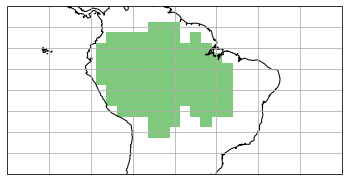

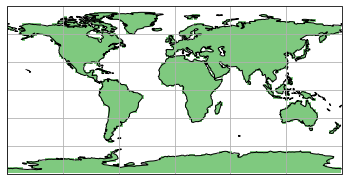

In [6]:
###### Define máscara cuenca del Amazonas

amazon = xr.open_dataset('amazon_mask.nc')
#amazon3 = (amazon.sel(lat = amazon > 0))
#display(amazon)
#display(1 * np.ones((amazon.dims['latitude'], amazon.dims['longitude'])))
      
def regrid(xarray):
    """Lleva a una grilla con los puntos entre 2 puntos
    adyacentes de la original que tenemos"""
    new_grid_lat = np.arange(-90, 92.5, 2.5)
    new_grid_lon = np.arange(-180, 180, 2.5)
    xarray2 = xarray.interp(longitude=new_grid_lon)
    return xarray2.interp(latitude=new_grid_lat)

amazon2 = regrid(amazon)
#amazon_mask = 1 * np.ones((amazon2.dims['latitude'], amazon2.dims['longitude'])) * np.isfinite(amazon2.where(amazon2 > 0))
amazon_mask = 1 * np.ones((amazon2.dims['latitude'], amazon2.dims['longitude'])) * np.isfinite(
                amazon2.regionmask.where(amazon2.regionmask > 0))
amazon_mask = amazon_mask.rename({'latitude':'lat', 'longitude':'lon'})
#display(amazon_mask)
#assign_coords({"lon": (((da.lon + 180) % 360) - 180)})
amazon_mask = amazon_mask.assign_coords({"lon": (amazon_mask.lon % 360)})
amazon_mask = amazon_mask.reindex(indexers={'lon':sorted(amazon_mask.coords['lon'].values)})
print('\nAmazonMask')
#display(amazon_mask)


ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([260, 340, 10, -30], crs=ccrs.PlateCarree())
amazon_mask.where(amazon_mask).plot(cmap='Accent', add_colorbar=False)
ax.coastlines()
ax.gridlines()
plt.show()
#pr_c5_26_close.mean(dim='time').where(amazon>).plot()

mask_land = regionmask.defined_regions.natural_earth.land_110.mask(pr_c5_ens)
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_extent([260, 340, 10, -30], crs=ccrs.PlateCarree())
mask_land.where(mask_land==0).plot(cmap='Accent', add_colorbar=False)
ax.coastlines()
ax.gridlines()
plt.show()


Defino el cálculo de correlación (E,P), desvíos de E y P,
$\Gamma = r_{P,E} \frac{\sigma_E}{\sigma_P}$ (gamma_std), $\Gamma = \frac{\sum_{i=1}^N P_iE_i}{\sum_{i=1}^N P_i^2}$ (gamma_id) para un mes

In [7]:
def gamma_ind(p, e, **kwargs):
    """"""
    
    month = kwargs.get('month', None)
    season = kwargs.get('season', None)
    if month:
        p = p.sel(time = p['time.month']==month)
        e = e.sel(time = e['time.month']==month)
    elif season:
        p = p.rolling(time=3, center=True).mean().dropna('time')
        display(p)
        e = e.rolling(time=3, center=True).mean().dropna('time')
        display(e)
    numerador_i = (p * e)
    denominador_i = (p * p)
    return numerador_i.sum(dim='time') / denominador_i.sum(dim='time')

def season_index(p, e, **kwargs):
    """Calcula correlacion,
    desvío estándar, gamma con
    los desvíos, gamma directo,
    season requiere el mes en
    torno al que está centrada,
    no lee 'DJF' o cosas así"""
    
    month = kwargs.get('month', None)
    season = kwargs.get('season', None)
    
    if month:
        p = p.sel(time = p['time.month']==month)
        e = e.sel(time = e['time.month']==month)
    elif season:
        p = p.rolling(time=3, center=True).mean().dropna('time')
        p = p.sel(time = p['time.month']==season)
        e = e.rolling(time=3, center=True).mean().dropna('time')
        e = e.sel(time = e['time.month']==season)
    numerador_i = (p * e)
    denominador_i = (p * p)
    
    corr = correlation(p, e, dim='time')
    stdev_p = p.std(dim='time')
    stdev_e = e.std(dim='time')
    gamma_std = correlation(p, e, dim='time') * e.std(dim='time') / p.std(dim='time')
    gamma_id = numerador_i.sum(dim='time') / denominador_i.sum(dim='time')
    return corr, stdev_p, stdev_e, gamma_std#, gamma_id

In [8]:
def sel_season(da, center_month, len_season=3):
    da_rav = da.rolling(time=len_season, center=True).mean().dropna('time')
    return da_rav.sel(time = da_rav['time.month']==center_month)

In [9]:
def gamma_ind(p, e, **kwargs):
    """"""
    
    month = kwargs.get('month', None)
    season = kwargs.get('season', None)
    if month:
        p = p.sel(time = p['time.month']==month)
        e = e.sel(time = e['time.month']==month)
    elif season:
        p = p.rolling(time=3, center=True).mean().dropna('time')
        display(p)
        e = e.rolling(time=3, center=True).mean().dropna('time')
        display(e)
    numerador_i = (p * e)
    denominador_i = (p * p)
    return numerador_i.sum(dim='time') / denominador_i.sum(dim='time')

def season_index(p, e, **kwargs):
    """Calcula correlacion,
    desvío estándar, gamma con
    los desvíos, gamma directo,
    season requiere el mes en
    torno al que está centrada,
    no lee 'DJF' o cosas así"""
    
    month = kwargs.get('month', None)
    season = kwargs.get('season', None)
    
    if month:
        p = p.sel(time = p['time.month']==month)
        e = e.sel(time = e['time.month']==month)
    elif season:
        p = p.rolling(time=3, center=True).mean().dropna('time')
        p = p.sel(time = p['time.month']==season)
        e = e.rolling(time=3, center=True).mean().dropna('time')
        e = e.sel(time = e['time.month']==season)
    numerador_i = (p * e)
    denominador_i = (p * p)
    
    corr = correlation(p, e, dim='time')
    stdev_p = p.std(dim='time')
    stdev_e = e.std(dim='time')
    gamma_std = correlation(p, e, dim='time') * e.std(dim='time') / p.std(dim='time')
    gamma_id = numerador_i.sum(dim='time') / denominador_i.sum(dim='time')
    return corr, stdev_p, stdev_e, gamma_std#, gamma_id

/home/tobi/programs/anaconda3/envs/cartopy018/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/tobi/programs/anaconda3/envs/cartopy018/lib/python3.7/site-packages/xarray/plot/facetgrid.py:371: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


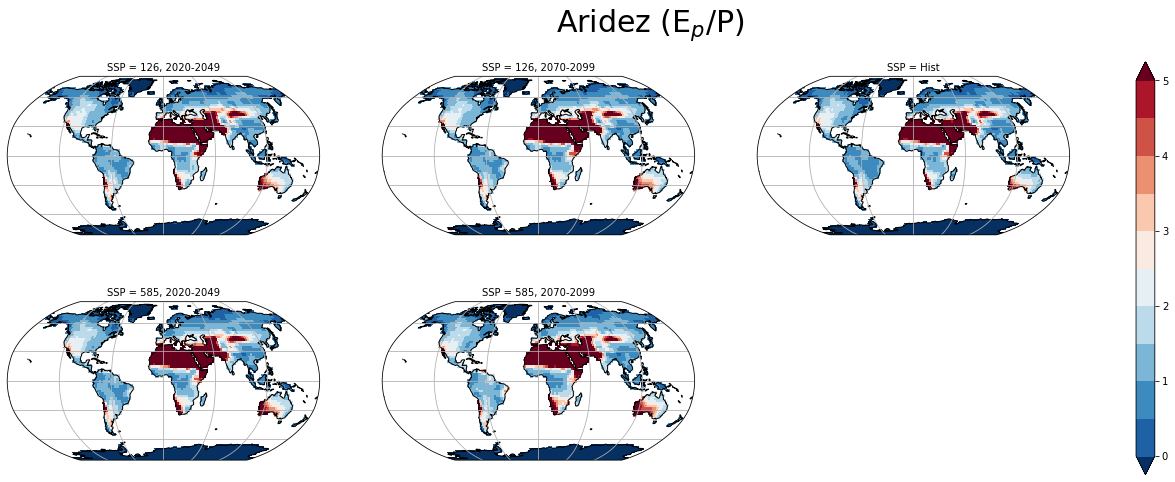

In [10]:
lista_aridez = []
lista_ep = [ep_c6_126_close, ep_c6_126_far, ep_c6_ens,  ep_c6_585_close, ep_c6_585_far]
lista_pr = [pr_c6_126_close, pr_c6_126_far, pr_c6_ens, pr_c6_585_close, pr_c6_585_far]
for i in range(0,len(lista_ep)):
    lista_aridez.append(lista_ep[i].where(np.isfinite(mask_land))/lista_pr[i].where(np.isfinite(mask_land)))
aridez = xr.concat(lista_aridez, pd.Index(['126, 2020-2049', '126, 2070-2099',
                            'Hist', '585, 2020-2049', '585, 2070-2099'], name='SSP'))
    
map_proj = ccrs.Robinson()
#ep_c6_hist.isel(r=1).mean(dim='time').plot()
p = aridez.mean(dim='time').plot(transform=ccrs.PlateCarree(),  # the data's projection
             col='SSP', col_wrap=3,  # multiplot settings
             aspect=2,
             size=3.8,
             subplot_kws={'projection': map_proj}, vmin=0, vmax=5, levels=11, colors='RdBu_r')
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()
plt.suptitle(r'Aridez (E$_p$/P)', fontsize=30)
plt.show()

/home/tobi/programs/anaconda3/envs/cartopy018/lib/python3.7/site-packages/xarray/plot/facetgrid.py:371: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


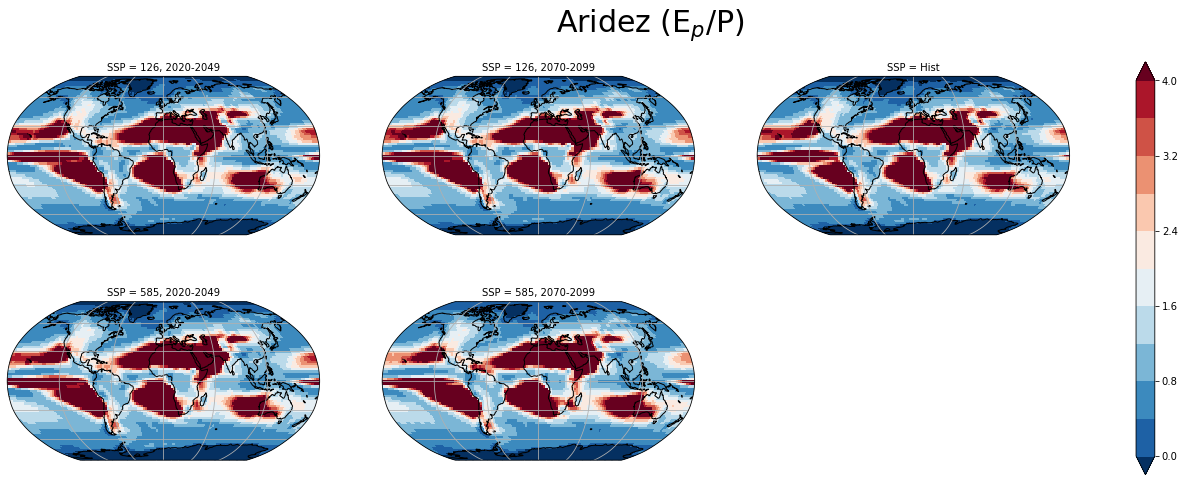

In [11]:
lista_aridez = []
lista_ep = [ep_c6_126_close, ep_c6_126_far, ep_c6_ens,  ep_c6_585_close, ep_c6_585_far]
lista_pr = [pr_c6_126_close, pr_c6_126_far, pr_c6_ens, pr_c6_585_close, pr_c6_585_far]
for i in range(0,len(lista_ep)):
    lista_aridez.append(lista_ep[i]/lista_pr[i])
aridez = xr.concat(lista_aridez, pd.Index(['126, 2020-2049', '126, 2070-2099',
                            'Hist', '585, 2020-2049', '585, 2070-2099'], name='SSP'))
    
map_proj = ccrs.Robinson()
#ep_c6_hist.isel(r=1).mean(dim='time').plot()
p = aridez.mean(dim='time').plot(transform=ccrs.PlateCarree(),  # the data's projection
             col='SSP', col_wrap=3,  # multiplot settings
             aspect=2,
             size=3.8,
             subplot_kws={'projection': map_proj}, vmin=0, vmax=4, levels=11, colors='RdBu_r')
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()
plt.suptitle(r'Aridez (E$_p$/P)', fontsize=30)
plt.show()

/home/tobi/programs/anaconda3/envs/cartopy018/lib/python3.7/site-packages/xarray/plot/facetgrid.py:371: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


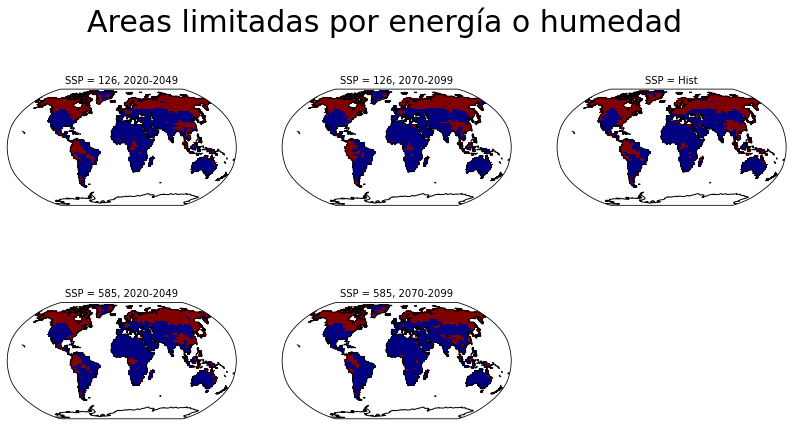

In [12]:
lista_ev = [ev_c6_126_close, ev_c6_126_far, ev_c6_ens, ev_c6_585_close, ev_c6_585_far]
lista_t = [t_c6_126_close, t_c6_126_far, t_c6_ens, t_c6_585_close, t_c6_585_far]
lista_pr = [pr_c6_126_close, pr_c6_126_far, pr_c6_ens, pr_c6_585_close, pr_c6_585_far]

lista_areas = []
for i in range(0,len(lista_ev)):
    e_t = correlation(lista_ev[i], lista_t[i], dim='time')
    e_p = correlation(lista_ev[i], lista_pr[i], dim='time')
    lista_areas.append((e_t - e_p).sel(lat = slice(-60,90)))

areas = xr.concat(lista_areas, pd.Index(['126, 2020-2049', '126, 2070-2099',
                            'Hist', '585, 2020-2049', '585, 2070-2099'], name='SSP'))

map_proj = ccrs.Robinson()
p = areas.where(np.isfinite(mask_land)).plot(transform=ccrs.PlateCarree(),
              col='SSP', col_wrap=3,
              aspect=1.2,
              size=3.6,
              subplot_kws={'projection': map_proj}, vmin=-2, vmax=2, levels=3,
              cmap='jet', add_colorbar=False)

for ax in p.axes.flat:
    ax.coastlines()
    #ax.gridlines()
plt.suptitle(r'Areas limitadas por energía o humedad', fontsize=30)
plt.show()


/home/tobi/programs/anaconda3/envs/cartopy018/lib/python3.7/site-packages/xarray/plot/facetgrid.py:371: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


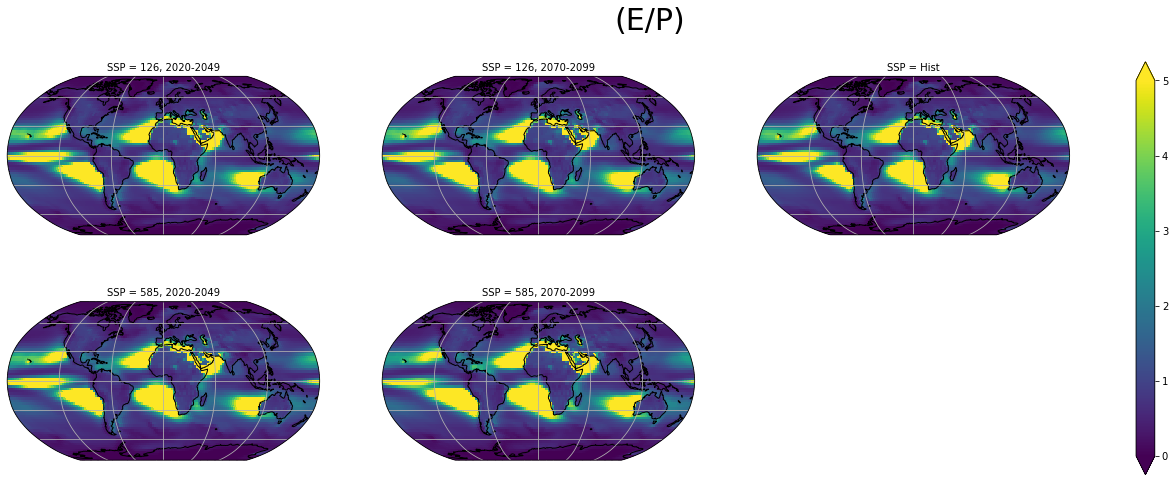

/home/tobi/programs/anaconda3/envs/cartopy018/lib/python3.7/site-packages/xarray/plot/facetgrid.py:371: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


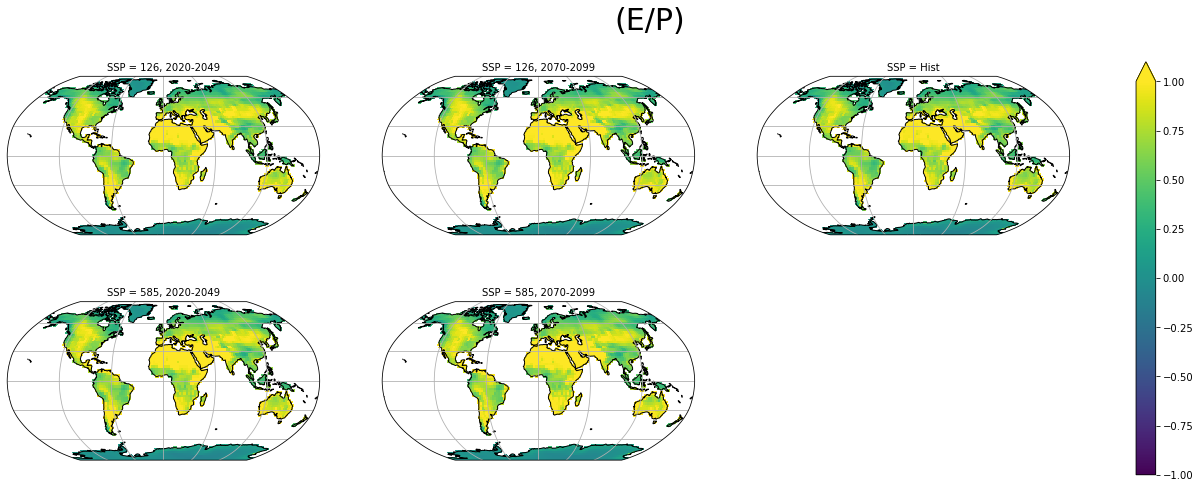

In [13]:
lista_aridez = []
lista_ev = [ev_c6_126_close, ev_c6_126_far, ev_c6_ens,  ev_c6_585_close, ev_c6_585_far]
lista_pr = [pr_c6_126_close, pr_c6_126_far, pr_c6_ens, pr_c6_585_close, pr_c6_585_far]
for i in range(0,len(lista_ev)):
    lista_aridez.append(lista_ev[i]/lista_pr[i])
aridez = xr.concat(lista_aridez, pd.Index(['126, 2020-2049', '126, 2070-2099',
                            'Hist', '585, 2020-2049', '585, 2070-2099'], name='SSP'))
    
map_proj = ccrs.Robinson()
#ev_c6_hist.isel(r=1).mean(dim='time').plot()
p = aridez.mean(dim='time').plot(transform=ccrs.PlateCarree(),  # the data's projection
             col='SSP', col_wrap=3,  # multiplot settings
             aspect=2,
             size=3.8,
             subplot_kws={'projection': map_proj},cmap='viridis', vmin=0, vmax=5)
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()
plt.suptitle(r'(E/P)', fontsize=30)
plt.show()

p = aridez.mean(dim='time').where(np.isfinite(mask_land)).plot(transform=ccrs.PlateCarree(),  # the data's projection
             col='SSP', col_wrap=3,  # multiplot settings
             aspect=2,
             size=3.8,
             subplot_kws={'projection': map_proj}, cmap='viridis', vmax=1)
for ax in p.axes.flat:
    ax.coastlines()
    ax.gridlines()
plt.suptitle(r'(E/P)', fontsize=30)
plt.show()

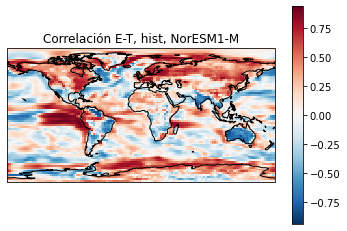

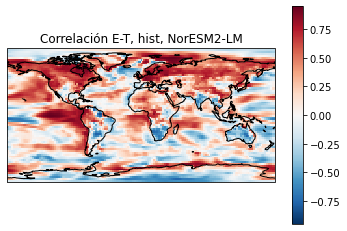

In [15]:
corr_e_t_hist_c5 = correlation(ev_c5_ens, t_c5_ens, dim='time')
ax = plt.axes(projection=ccrs.PlateCarree())
corr_e_t_hist_c5.plot(transform=ccrs.PlateCarree())
plt.title('Correlación E-T, hist, NorESM1-M')
ax.coastlines()
plt.show()

corr_e_t_hist_c6 = correlation(ev_c6_ens, t_c6_ens, dim='time')
ax = plt.axes(projection=ccrs.PlateCarree())
corr_e_t_hist_c6.plot(transform=ccrs.PlateCarree())
plt.title('Correlación E-T, hist, NorESM2-LM')
ax.coastlines()
plt.show()

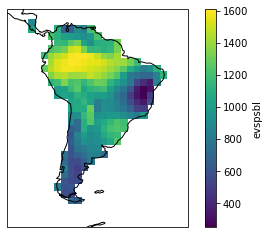

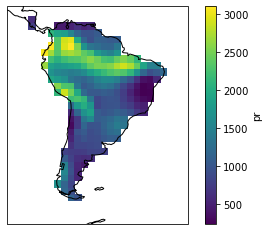

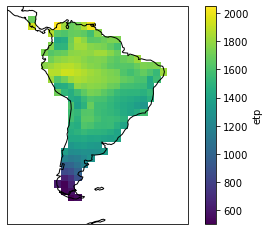

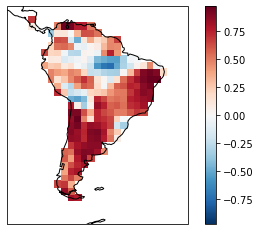

In [16]:
def sel_latlon(da, lat=slice(-60,14), lon=slice(270,330)):
    return da.sel(lat=lat).sel(lon=lon)

ev_sa_c5_hist = sel_latlon(ev_c5_ens)
ax = plt.axes(projection=ccrs.PlateCarree())
ev_sa_c5_hist.mean(dim='time').where(mask_land == 0).plot()
ax.coastlines()
plt.show()

pr_sa_c5_hist = sel_latlon(pr_c5_ens)
ax = plt.axes(projection=ccrs.PlateCarree())
pr_sa_c5_hist.mean(dim='time').where(mask_land == 0).plot()
ax.coastlines()
plt.show()

ep_sa_c5_hist = sel_latlon(ep_c5_ens)
ax = plt.axes(projection=ccrs.PlateCarree())
ep_sa_c5_hist.mean(dim='time').where(mask_land == 0).plot()
ax.coastlines()
plt.show()

corr = correlation(ev_sa_c5_hist, pr_sa_c5_hist, dim='time')
ax = plt.axes(projection=ccrs.PlateCarree())
corr.where(mask_land == 0).plot()
ax.coastlines()
plt.show()

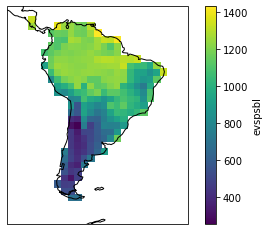

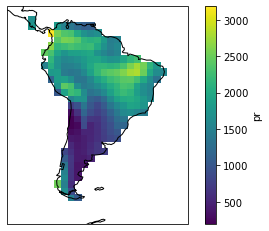

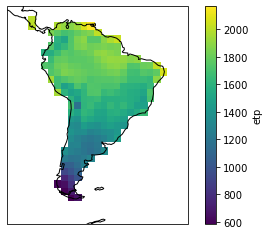

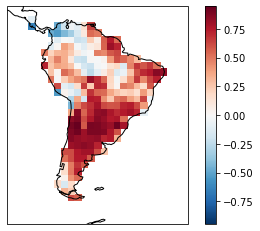

In [17]:
def sel_latlon(da, lat=slice(-60,14), lon=slice(270,330)):
    return da.sel(lat=lat).sel(lon=lon)

ev_sa_c6_hist = sel_latlon(ev_c6_ens)
ax = plt.axes(projection=ccrs.PlateCarree())
ev_sa_c6_hist.mean(dim='time').where(mask_land == 0).plot()
ax.coastlines()
plt.show()

pr_sa_c6_hist = sel_latlon(pr_c6_ens)
ax = plt.axes(projection=ccrs.PlateCarree())
pr_sa_c6_hist.mean(dim='time').where(mask_land == 0).plot()
ax.coastlines()
plt.show()

ep_sa_c5_hist = sel_latlon(ep_c6_ens)
ax = plt.axes(projection=ccrs.PlateCarree())
ep_sa_c5_hist.mean(dim='time').where(mask_land == 0).plot()
ax.coastlines()
plt.show()

corr = correlation(ev_sa_c6_hist, pr_sa_c6_hist, dim='time')
ax = plt.axes(projection=ccrs.PlateCarree())
corr.where(mask_land == 0).plot()
ax.coastlines()
plt.show()

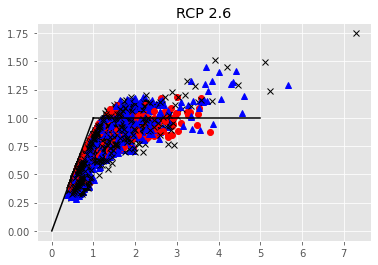

In [46]:

aridez = ep_c5_ens / pr_c5_ens
aridez_26_close = ep_c5_26_close / pr_c5_26_close
aridez_26_far = ep_c5_26_far / pr_c5_26_far
runoff = ev_c5_ens / pr_c5_ens
runoff_26_close = ev_c5_26_close / pr_c5_26_close
runoff_26_far = ev_c5_26_far / pr_c5_26_far

#print(runoff.sel(lon=282.5).sel(lat=-7.5))
#plt.plot(aridez.sel(lon=282.5, lat=-7.5), runoff.sel(lon=282.5, lat=-7.5), 'o')

da_stacked = amazon_mask.where(amazon_mask == 1).stack(x=['lon', 'lat'])
da_stacked = da_stacked[da_stacked.notnull()]
coords_amazonas = da_stacked.x.values

with plt.style.context('ggplot'):
    for i in coords_amazonas:
        plt.plot(aridez.sel(lon=i[0], lat=i[1]), runoff.sel(lon=i[0], lat=i[1]),'o', color='r')
        plt.plot(aridez_26_close.sel(lon=i[0], lat=i[1]), runoff_26_close.sel(lon=i[0], lat=i[1]),'^', color='b')
        plt.plot(aridez_26_far.sel(lon=i[0], lat=i[1]), runoff_26_far.sel(lon=i[0], lat=i[1]),'x', color='k')
    
    plt.plot([0,1], [0,1], color='k')
    plt.plot([1, 5], [1, 1], color='k')
    plt.title('RCP 2.6')
    plt.show() 


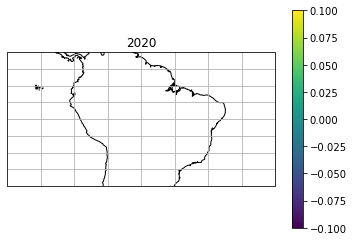

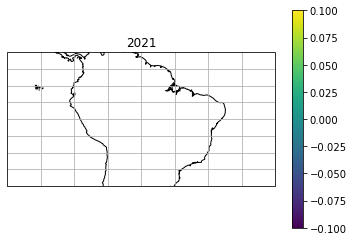

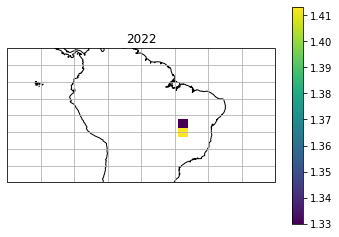

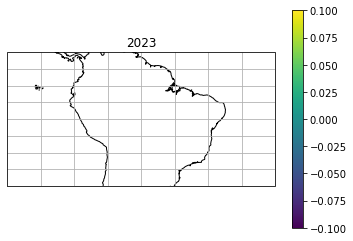

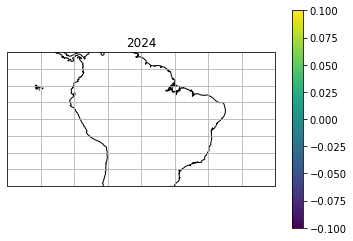

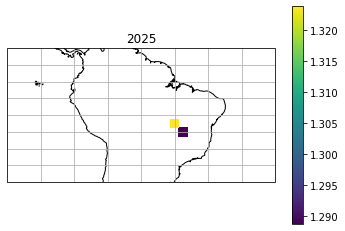

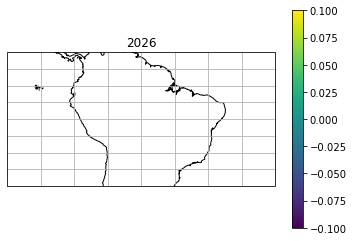

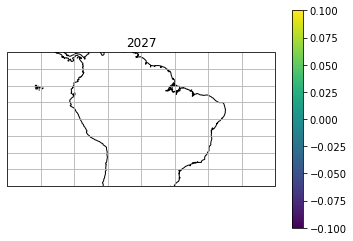

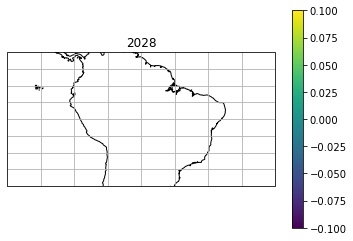

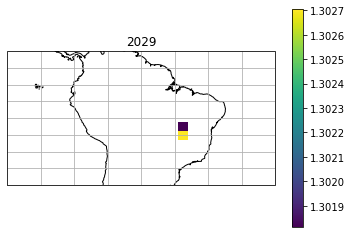

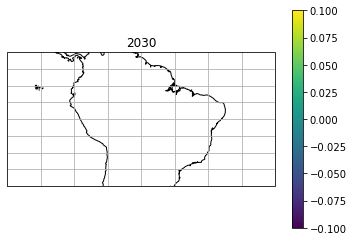

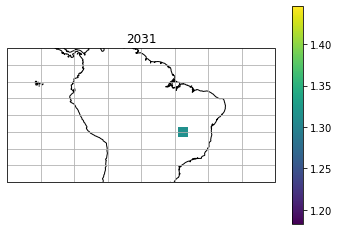

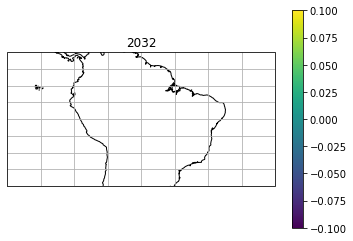

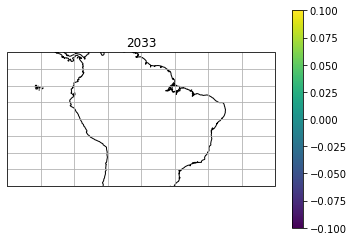

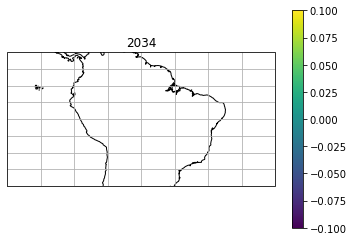

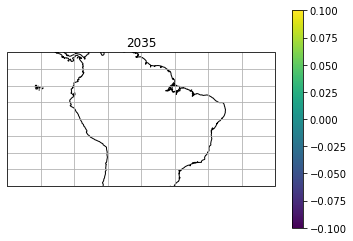

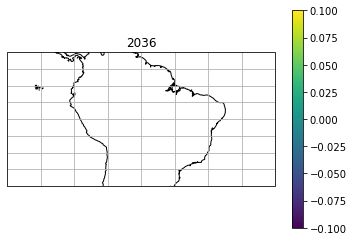

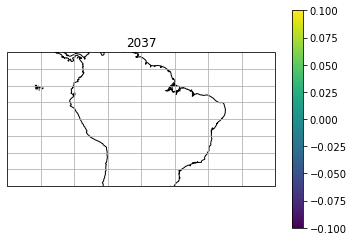

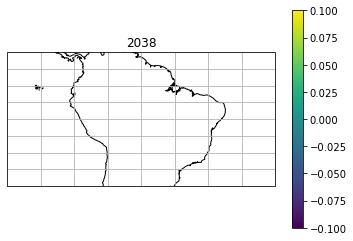

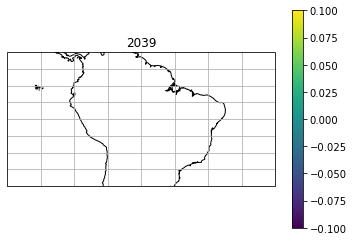

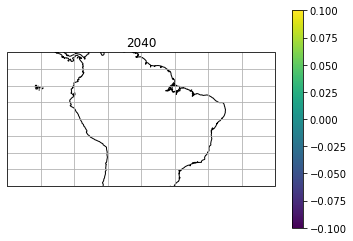

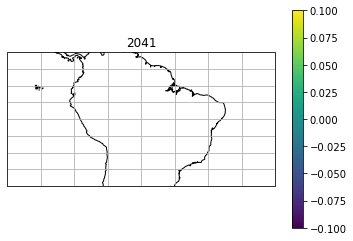

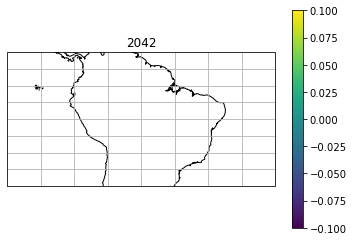

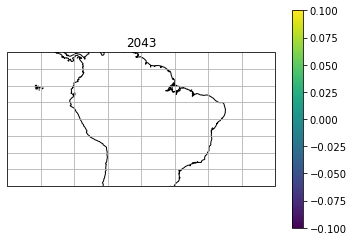

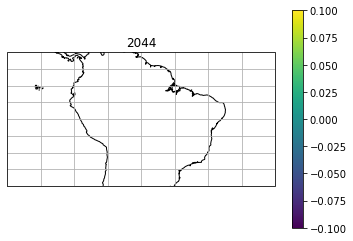

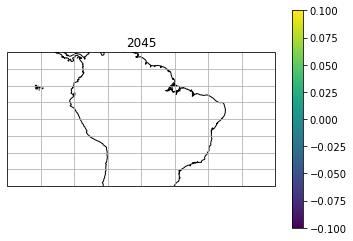

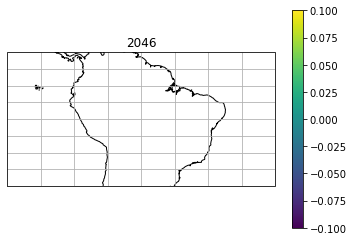

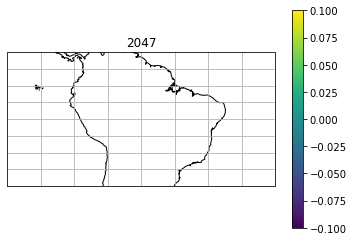

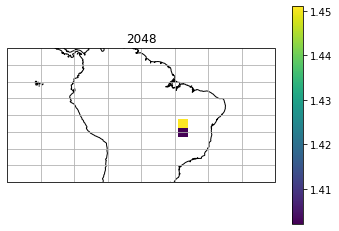

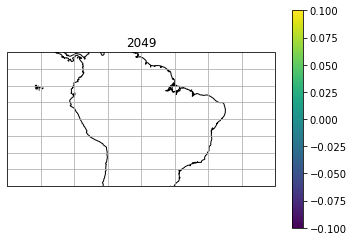

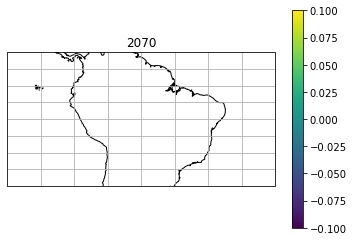

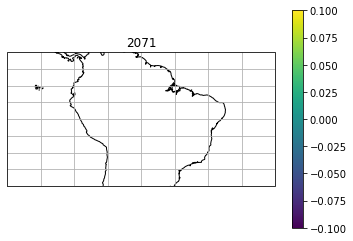

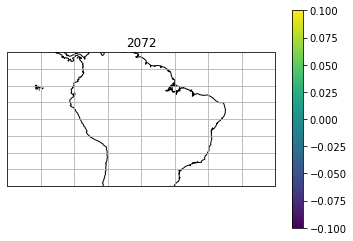

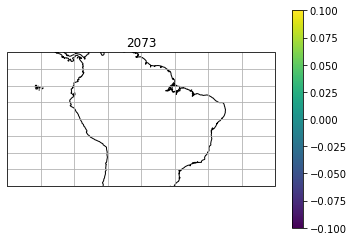

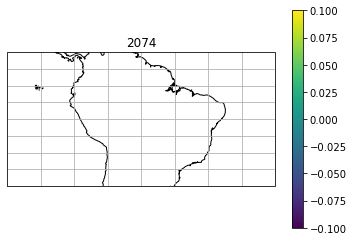

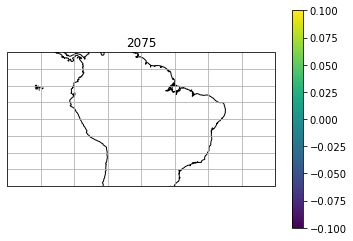

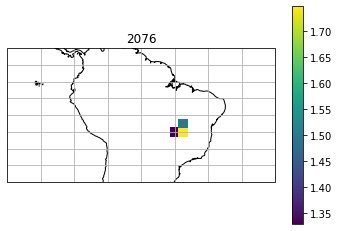

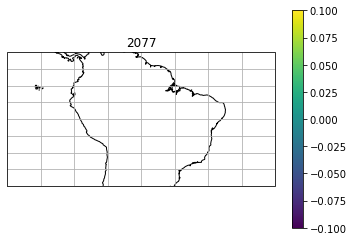

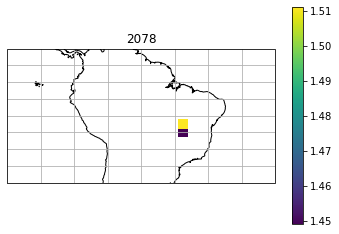

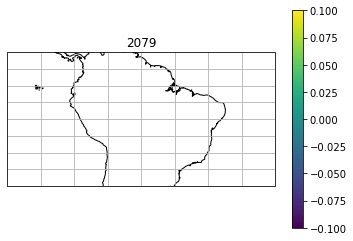

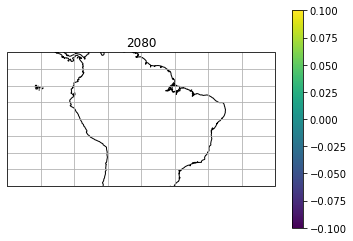

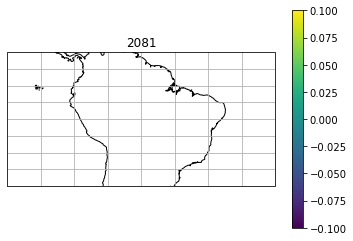

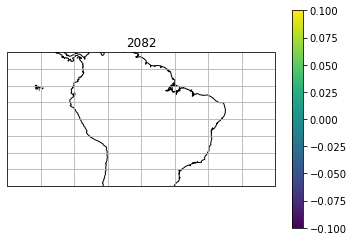

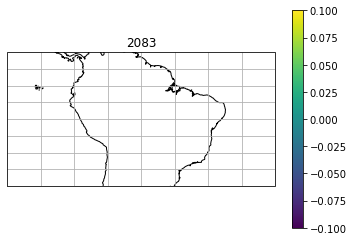

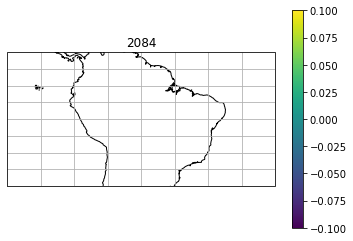

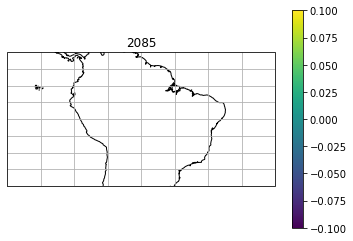

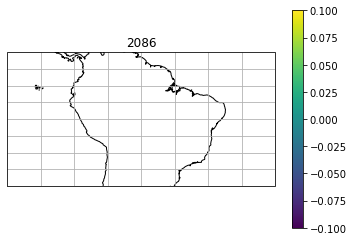

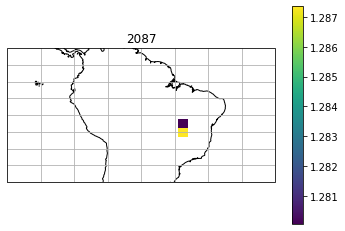

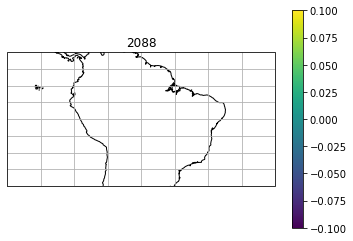

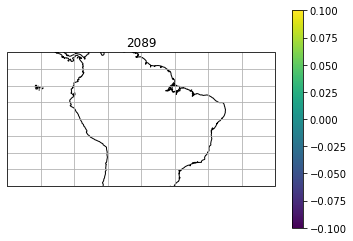

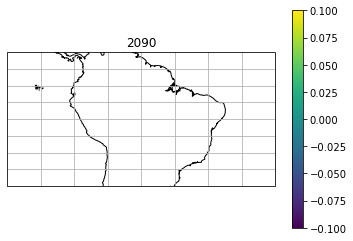

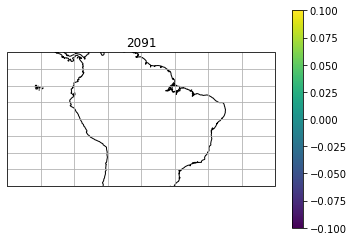

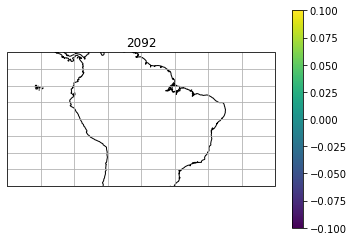

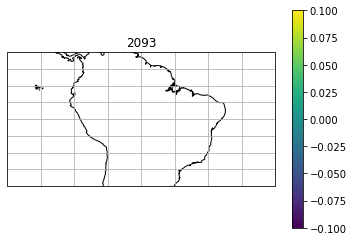

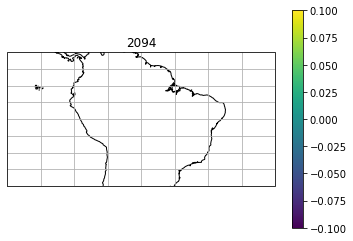

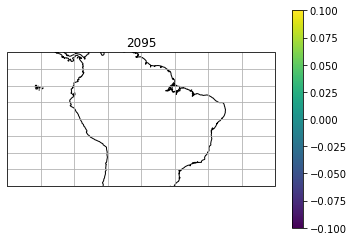

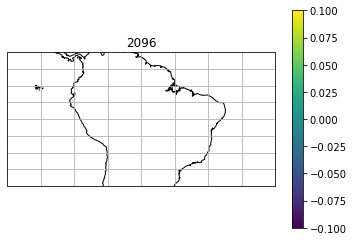

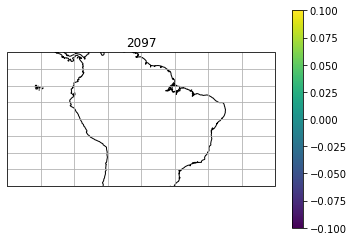

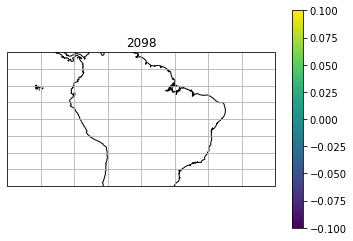

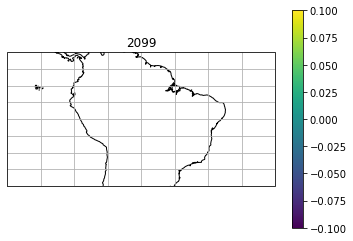

In [45]:
for i in range(0,30):
    ax = plt.axes(projection=ccrs.PlateCarree())
    runoff_26_close.isel(time=i).where(amazon_mask == 1).where(runoff_26_close.isel(time=i) > 1.25).plot()
    ax.set_extent([260, 340, 10, -30], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines()
    plt.title(str(runoff_26_close.time.dt.year[i].values))
    plt.show()

for i in range(0,30):
    ax = plt.axes(projection=ccrs.PlateCarree())
    runoff_26_far.isel(time=i).where(amazon_mask == 1).where(runoff_26_far.isel(time=i) > 1.25).plot()
    ax.set_extent([260, 340, 10, -30], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines()
    plt.title(str(runoff_26_far.time.dt.year[i].values))
    plt.show()

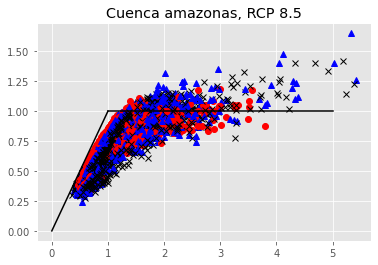

In [43]:
aridez = ep_c5_ens / pr_c5_ens
aridez_85_close = ep_c5_85_close / pr_c5_85_close
aridez_85_far = ep_c5_85_far / pr_c5_85_far
runoff = ev_c5_ens / pr_c5_ens
runoff_85_close = ev_c5_85_close / pr_c5_85_close
runoff_85_far = ev_c5_85_far / pr_c5_85_far

#plt.plot(aridez.sel(lon=282.5, lat=-7.5), runoff.sel(lon=282.5, lat=-7.5), 'o')

da_stacked = amazon_mask.where(amazon_mask == 1).stack(x=['lon', 'lat'])
da_stacked = da_stacked[da_stacked.notnull()]
coords_amazonas = da_stacked.x.values

with plt.style.context('ggplot'):
    for i in coords_amazonas:
        plt.plot(aridez.sel(lon=i[0], lat=i[1]), runoff.sel(lon=i[0], lat=i[1]),'o', color='r')
        plt.plot(aridez_85_close.sel(lon=i[0], lat=i[1]), runoff_85_close.sel(lon=i[0], lat=i[1]),'^', color='b')
        plt.plot(aridez_85_far.sel(lon=i[0], lat=i[1]), runoff_85_far.sel(lon=i[0], lat=i[1]),'x', color='k')
    
        plt.plot()
    plt.plot([0,1], [0,1], color='k')
    plt.plot([1, 5], [1, 1], color='k')
    plt.title('Cuenca amazonas, RCP 8.5')
    plt.show()
        


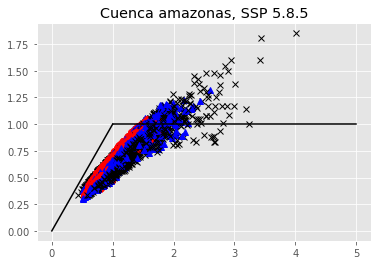

In [136]:
aridez = ep_c6_ens / pr_c6_ens
aridez_585_close = ep_c6_585_close / pr_c6_585_close
aridez_585_far = ep_c6_585_far / pr_c6_585_far
runoff = ev_c6_ens / pr_c6_ens
runoff_585_close = ev_c6_585_close / pr_c6_585_close
runoff_585_far = ev_c6_585_far / pr_c6_585_far

#plt.plot(aridez.sel(lon=282.5, lat=-7.5), runoff.sel(lon=282.5, lat=-7.5), 'o')

da_stacked = amazon_mask.where(amazon_mask == 1).stack(x=['lon', 'lat'])
da_stacked = da_stacked[da_stacked.notnull()]
coords_amazonas = da_stacked.x.values

with plt.style.context('ggplot'):
    for i in coords_amazonas:
        plt.plot(aridez.sel(lon=i[0], lat=i[1]), runoff.sel(lon=i[0], lat=i[1]),'o', color='r')
        plt.plot(aridez_585_close.sel(lon=i[0], lat=i[1]), runoff_585_close.sel(lon=i[0], lat=i[1]),'^', color='b')
        plt.plot(aridez_585_far.sel(lon=i[0], lat=i[1]), runoff_585_far.sel(lon=i[0], lat=i[1]),'x', color='k')
    
        plt.plot()
    plt.plot([0,1], [0,1], color='k')
    plt.plot([1, 5], [1, 1], color='k')
    plt.title('Cuenca amazonas, SSP 5.8.5')
    plt.show()
        


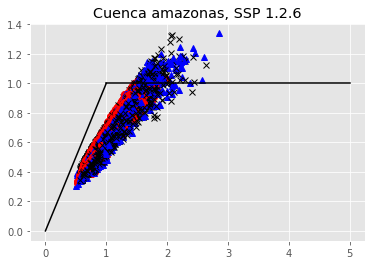

In [139]:
aridez = ep_c6_ens / pr_c6_ens

aridez_126_close = ep_c6_126_close / pr_c6_126_close
aridez_126_far = ep_c6_126_far / pr_c6_126_far
runoff = ev_c6_ens / pr_c6_ens
runoff_126_close = ev_c6_126_close / pr_c6_126_close
runoff_126_far = ev_c6_126_far / pr_c6_126_far

aridez_585_close = ep_c6_585_close / pr_c6_585_close
aridez_585_far = ep_c6_585_far / pr_c6_585_far
runoff = ev_c6_ens / pr_c6_ens
runoff_585_close = ev_c6_585_close / pr_c6_585_close
runoff_585_far = ev_c6_585_far / pr_c6_585_far


#plt.plot(aridez.sel(lon=282.5, lat=-7.5), runoff.sel(lon=282.5, lat=-7.5), 'o')

da_stacked = amazon_mask.where(amazon_mask == 1).stack(x=['lon', 'lat'])
da_stacked = da_stacked[da_stacked.notnull()]
coords_amazonas = da_stacked.x.values

with plt.style.context('ggplot'):
    for i in coords_amazonas:
        plt.plot(aridez.sel(lon=i[0], lat=i[1]), runoff.sel(lon=i[0], lat=i[1]),'o', color='r')
        plt.plot(aridez_126_close.sel(lon=i[0], lat=i[1]), runoff_126_close.sel(lon=i[0], lat=i[1]),'^', color='b')
        plt.plot(aridez_126_far.sel(lon=i[0], lat=i[1]), runoff_126_far.sel(lon=i[0], lat=i[1]),'x', color='k')
    
        plt.plot()
    plt.plot([0,1], [0,1], color='k')
    plt.plot([1, 5], [1, 1], color='k')
    plt.title('Cuenca amazonas, SSP 1.2.6')
    plt.show()
        


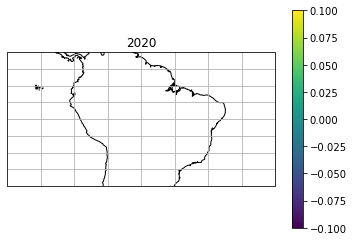

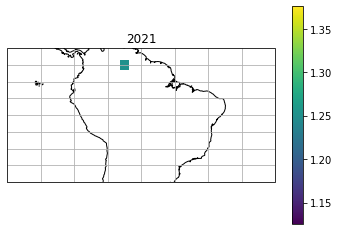

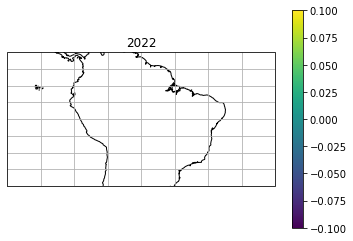

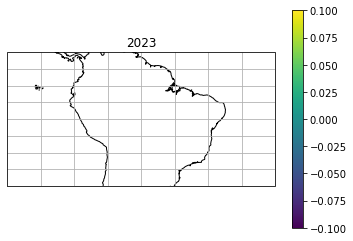

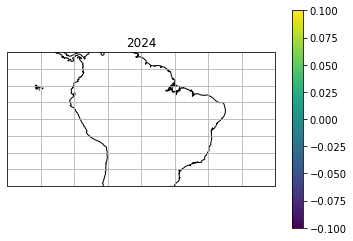

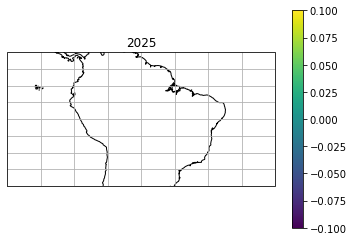

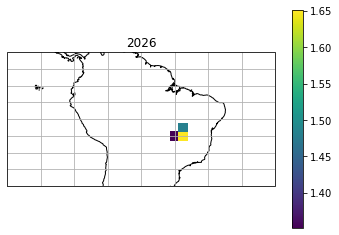

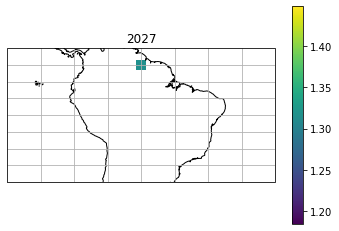

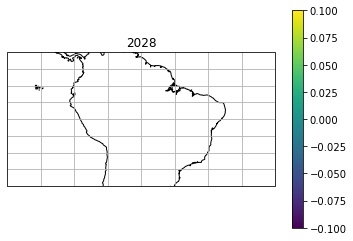

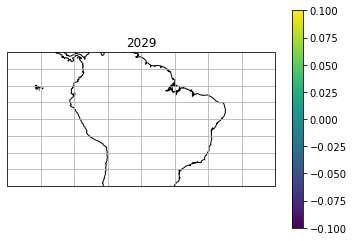

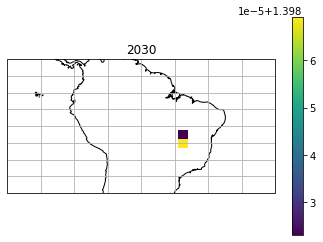

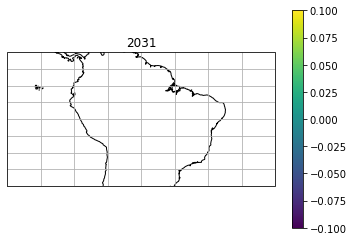

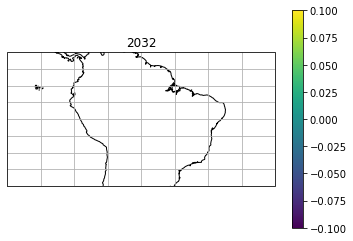

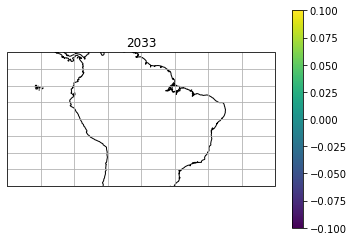

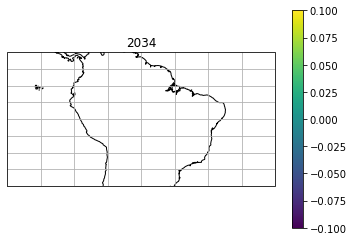

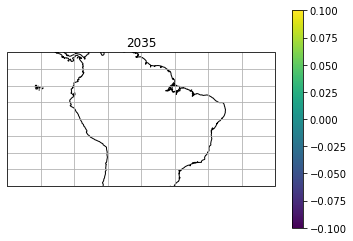

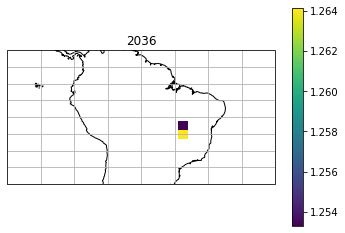

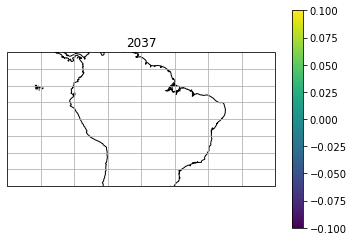

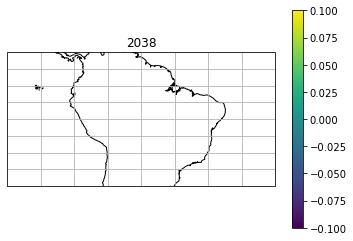

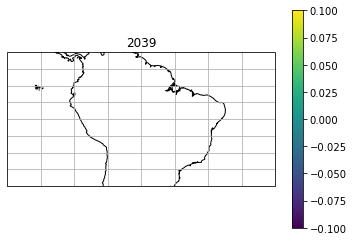

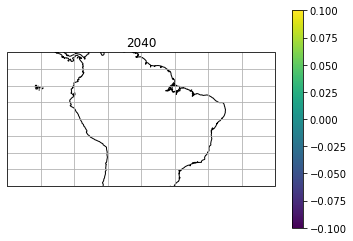

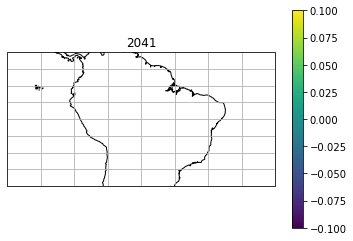

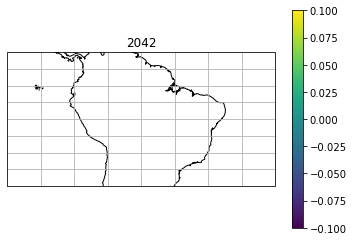

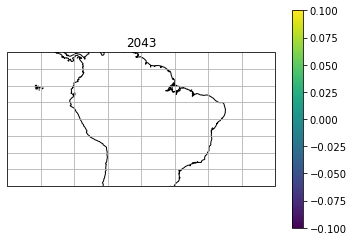

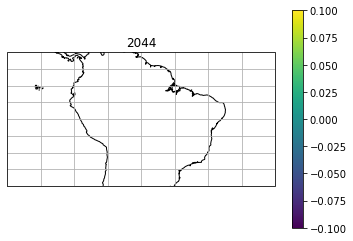

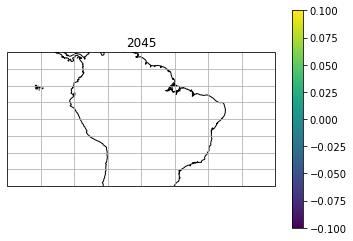

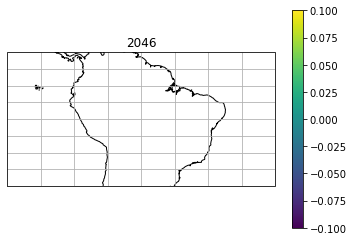

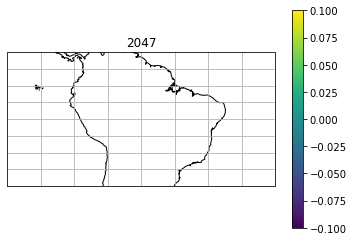

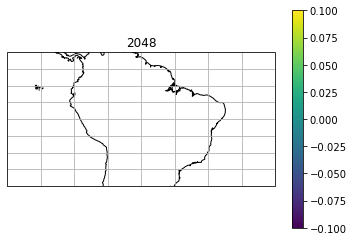

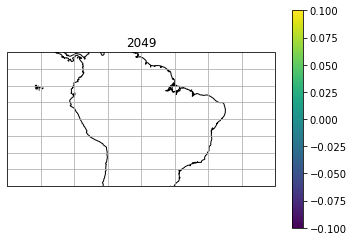

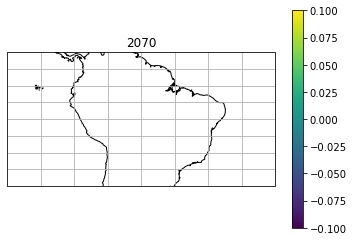

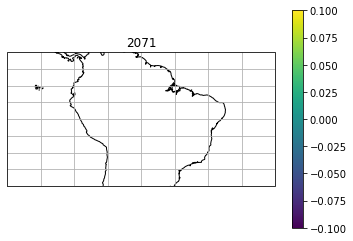

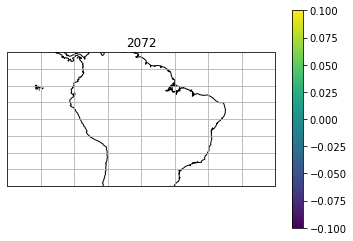

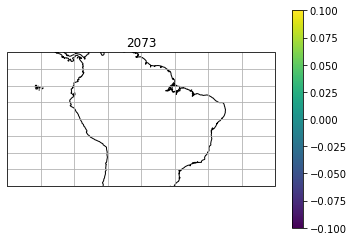

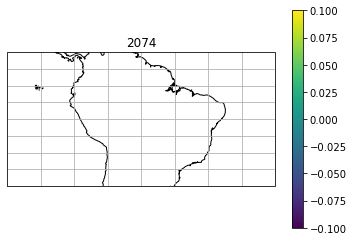

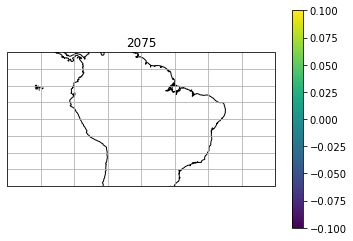

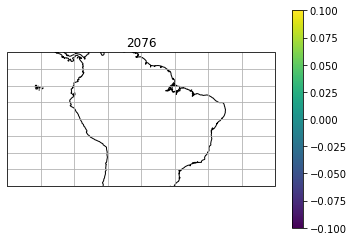

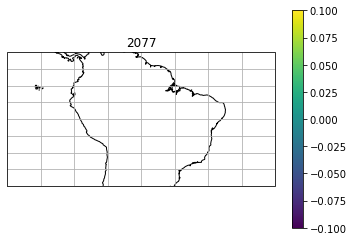

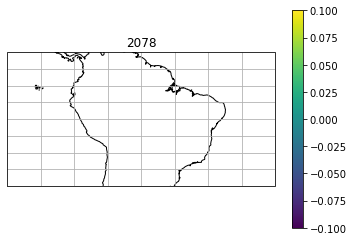

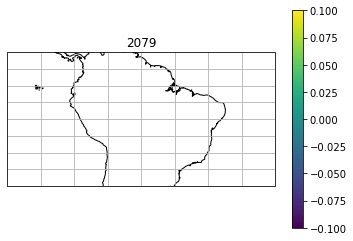

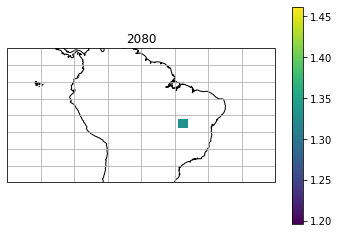

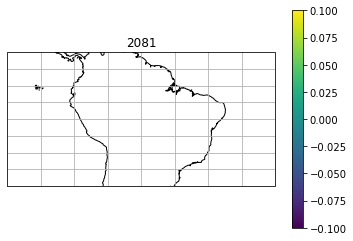

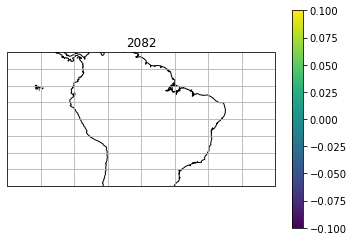

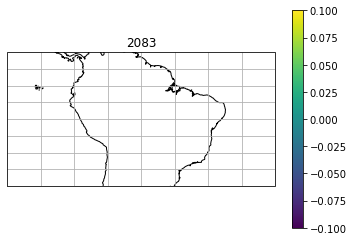

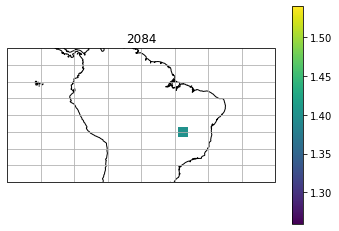

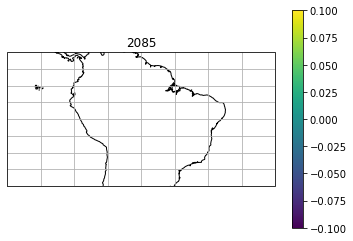

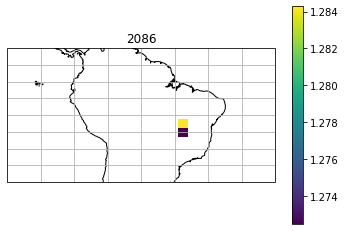

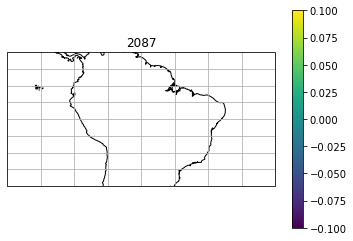

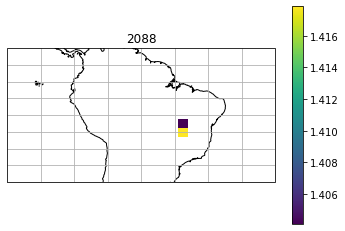

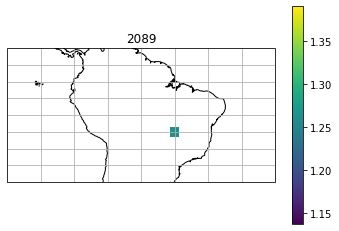

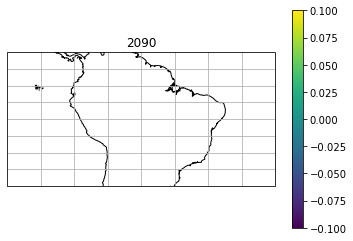

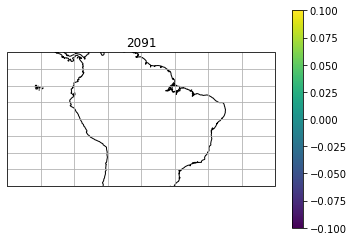

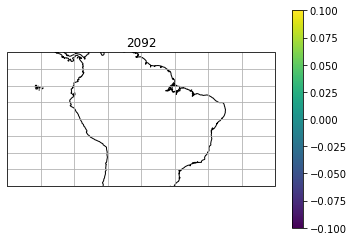

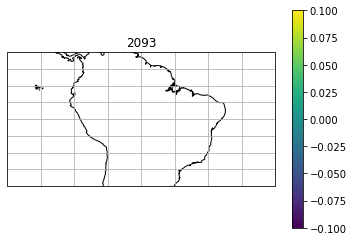

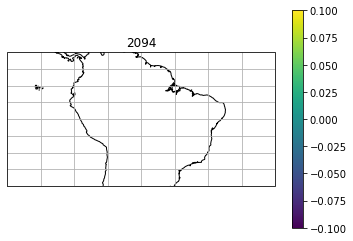

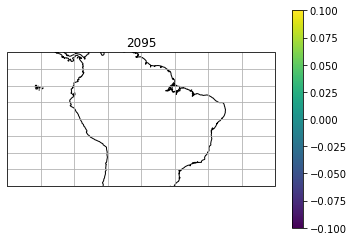

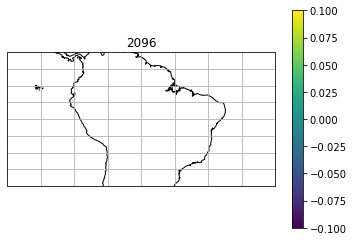

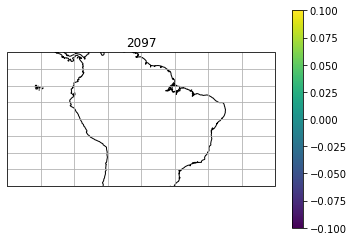

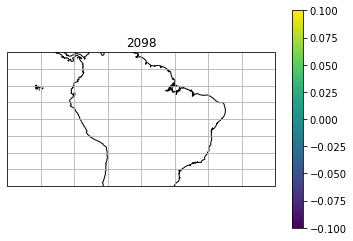

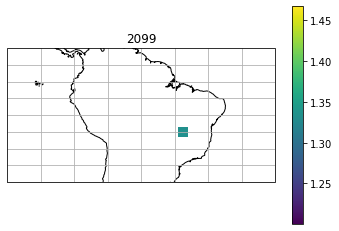

In [39]:
for i in range(0,30):
    ax = plt.axes(projection=ccrs.PlateCarree())
    runoff_85_close.isel(time=i).where(amazon_mask == 1).where(runoff_85_close.isel(time=i) > 1.25).plot()
    ax.set_extent([260, 340, 10, -30], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines()
    plt.title(str(runoff_85_close.time.dt.year[i].values))
    plt.show()

for i in range(0,30):
    ax = plt.axes(projection=ccrs.PlateCarree())
    runoff_85_far.isel(time=i).where(amazon_mask == 1).where(runoff_85_far.isel(time=i) > 1.25).plot()
    ax.set_extent([260, 340, 10, -30], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines()
    plt.title(str(runoff_85_far.time.dt.year[i].values))
    plt.show()

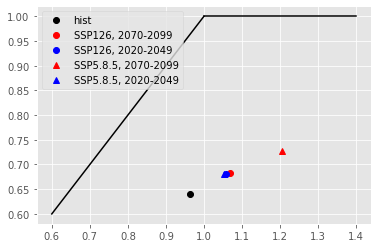

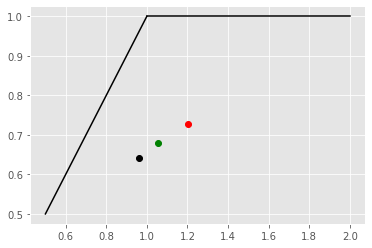

In [146]:
aridez = ep_c6_ens / pr_c6_ens

aridez_126_close = ep_c6_126_close / pr_c6_126_close
aridez_126_far = ep_c6_126_far / pr_c6_126_far
runoff = ev_c6_ens / pr_c6_ens
runoff_126_close = ev_c6_126_close / pr_c6_126_close
runoff_126_far = ev_c6_126_far / pr_c6_126_far

aridez_585_close = ep_c6_585_close / pr_c6_585_close
aridez_585_far = ep_c6_585_far / pr_c6_585_far
runoff = ev_c6_ens / pr_c6_ens
runoff_585_close = ev_c6_585_close / pr_c6_585_close
runoff_585_far = ev_c6_585_far / pr_c6_585_far

with plt.style.context('ggplot'):

    plt.plot(aridez.where(amazon_mask == 1).mean(), runoff.where(amazon_mask == 1).mean(), 'o', color='k', label='hist')

    plt.plot(aridez_126_far.where(amazon_mask == 1).mean(), runoff_126_far.where(amazon_mask == 1).mean(), 'o', color='r',
            label='SSP126, 2070-2099')
    plt.plot(aridez_126_close.where(amazon_mask == 1).mean(), runoff_126_close.where(amazon_mask == 1).mean(), 'o', color='b',
             label='SSP126, 2020-2049')
    plt.plot(aridez_585_far.where(amazon_mask == 1).mean(), runoff_585_far.where(amazon_mask == 1).mean(), '^', color='r',
             label='SSP5.8.5, 2070-2099')
    plt.plot(aridez_585_close.where(amazon_mask == 1).mean(), runoff_585_close.where(amazon_mask == 1).mean(), '^', color='b',
             label='SSP5.8.5, 2020-2049')

    plt.legend(loc=2)
    plt.plot([0.6,1], [0.6,1], color='k')
    plt.plot([1, 1.4], [1, 1], color='k')
    plt.show()
    
    plt.plot(aridez.where(amazon_mask == 1).mean(), runoff.where(amazon_mask == 1).mean(), 'o', color='k')
    plt.plot(aridez_585_close.where(amazon_mask == 1).mean(), runoff_585_close.where(amazon_mask == 1).mean(), 'o', color='g')
    plt.plot(aridez_585_far.where(amazon_mask == 1).mean(), runoff_585_far.where(amazon_mask == 1).mean(), 'o', color='r')
    
    plt.plot([0.5,1], [0.5,1], color='k')
    plt.plot([1, 2], [1, 1], color='k')
    plt.show()

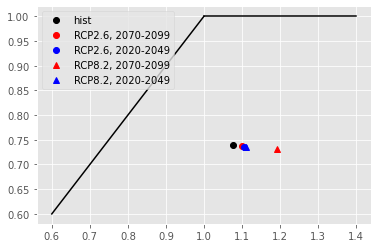

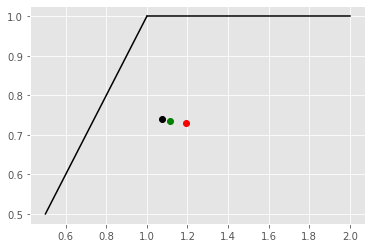

In [144]:
aridez = ep_c5_ens / pr_c5_ens

aridez = ep_c5_ens / pr_c5_ens
aridez_26_close = ep_c5_26_close / pr_c5_26_close
aridez_26_far = ep_c5_26_far / pr_c5_26_far
runoff = ev_c5_ens / pr_c5_ens
runoff_26_close = ev_c5_26_close / pr_c5_26_close
runoff_26_far = ev_c5_26_far / pr_c5_26_far

aridez_85_close = ep_c5_85_close / pr_c5_85_close
aridez_85_far = ep_c5_85_far / pr_c5_85_far
runoff = ev_c5_ens / pr_c5_ens
runoff_85_close = ev_c5_85_close / pr_c5_85_close
runoff_85_far = ev_c5_85_far / pr_c5_85_far


with plt.style.context('ggplot'):

    plt.plot(aridez.where(amazon_mask == 1).mean(), runoff.where(amazon_mask == 1).mean(), 'o', color='k', label='hist')

    plt.plot(aridez_26_far.where(amazon_mask == 1).mean(), runoff_26_far.where(amazon_mask == 1).mean(), 'o', color='r',
            label='RCP2.6, 2070-2099')
    
    plt.plot(aridez_26_close.where(amazon_mask == 1).mean(), runoff_26_close.where(amazon_mask == 1).mean(), 'o', color='b',
             label='RCP2.6, 2020-2049')
    plt.plot(aridez_85_far.where(amazon_mask == 1).mean(), runoff_85_far.where(amazon_mask == 1).mean(), '^', color='r',
             label='RCP8.2, 2070-2099')
    plt.plot(aridez_85_close.where(amazon_mask == 1).mean(), runoff_85_close.where(amazon_mask == 1).mean(), '^', color='b',
             label='RCP8.2, 2020-2049')

    plt.legend(loc=2)
    plt.plot([0.6,1], [0.6,1], color='k')
    plt.plot([1, 1.4], [1, 1], color='k')
    plt.show()
    
    plt.plot(aridez.where(amazon_mask == 1).mean(), runoff.where(amazon_mask == 1).mean(), 'o', color='k')
    plt.plot(aridez_85_close.where(amazon_mask == 1).mean(), runoff_85_close.where(amazon_mask == 1).mean(), 'o', color='g')
    plt.plot(aridez_85_far.where(amazon_mask == 1).mean(), runoff_85_far.where(amazon_mask == 1).mean(), 'o', color='r')
    plt.plot([0.5,1], [0.5,1], color='k')
    plt.plot([1, 2], [1, 1], color='k')
    plt.show()

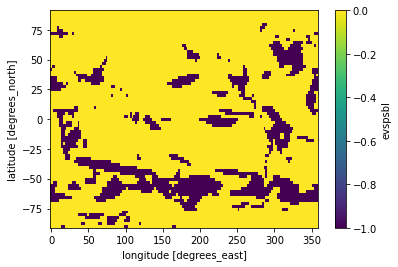

In [98]:
def calculate_deltas(ev1, ev2, ep1, ep2, pr1, pr2):
    return (ev2.mean(dim='time') - ev1.mean(dim='time'),
            ep2.mean(dim='time') - ep1.mean(dim='time'),
            pr2.mean(dim='time') - pr1.mean(dim='time'))

delta_ev, delta_ep, delta_pr = calculate_deltas(ev_c5_ens, ev_c5_85_far,
                                                ep_c5_ens, ep_c5_85_far,
                                                pr_c5_ens, pr_c5_85_far)

delta_ev_pos = 1 * np.ones([len(delta_ev['lat']), len(delta_ev['lon'])]) * np.isfinite(delta_ev.where(delta_ev > 0))
delta_ep_pos = 2 * np.ones([len(delta_ep['lat']), len(delta_ep['lon'])]) * np.isfinite(delta_ep.where(delta_ep > 0))
delta_pr_pos = 3 * np.ones([len(delta_ep['lat']), len(delta_ep['lon'])]) * np.isfinite(delta_ep.where(delta_ep > 0))

delta_ev_neg = -1 * np.ones([len(delta_ev['lat']), len(delta_ev['lon'])]) * np.isfinite(delta_ev.where(delta_ev < 0))
delta_ep_neg = -2 * np.ones([len(delta_ep['lat']), len(delta_ep['lon'])]) * np.isfinite(delta_ep.where(delta_ep < 0))
delta_pr_neg = -3 * np.ones([len(delta_ep['lat']), len(delta_ep['lon'])]) * np.isfinite(delta_ep.where(delta_ep < 0))

d_ev_pr_0_1_5 = 

delta_ev_neg.plot()

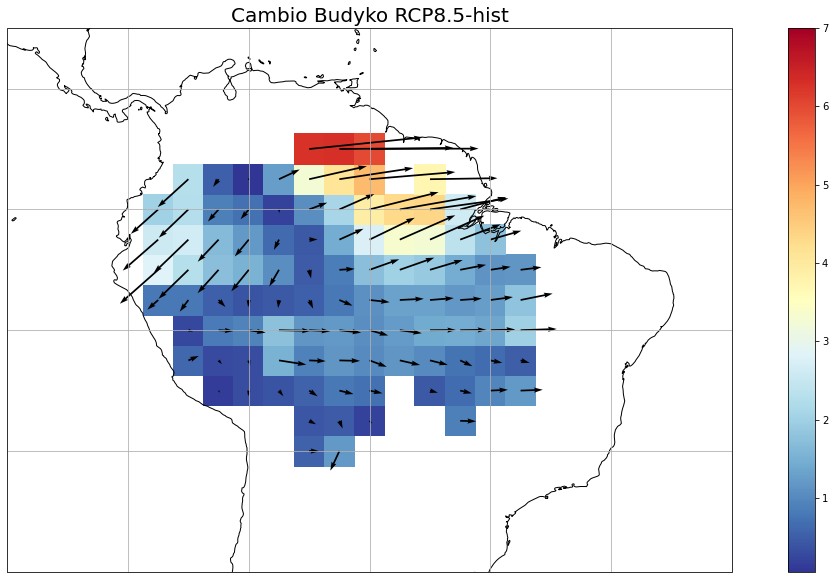

In [149]:
u = (ep_c5_85_far.mean(dim='time') / pr_c5_85_far.mean(dim='time')) - (
     ep_c5_ens.mean(dim='time') / pr_c5_ens.mean(dim='time'))

v = (ev_c5_85_far.mean(dim='time') / pr_c5_85_far.mean(dim='time')) - (
     ev_c5_ens.mean(dim='time') / pr_c5_ens.mean(dim='time'))

mod_change = np.sqrt((u*u)  + (v*v))

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([270, 330, 15, -30], crs=ccrs.PlateCarree())
(mod_change * 10).where(amazon_mask == 1).plot(cmap='RdYlBu_r', vmax=7)
ax.coastlines()
ax.gridlines()
ax.quiver(u.lon.values, u.lat.values, u.where(amazon_mask == 1), v.where(amazon_mask == 1), scale=4)
plt.title('Cambio Budyko RCP8.5-hist', fontsize=20)
plt.show()

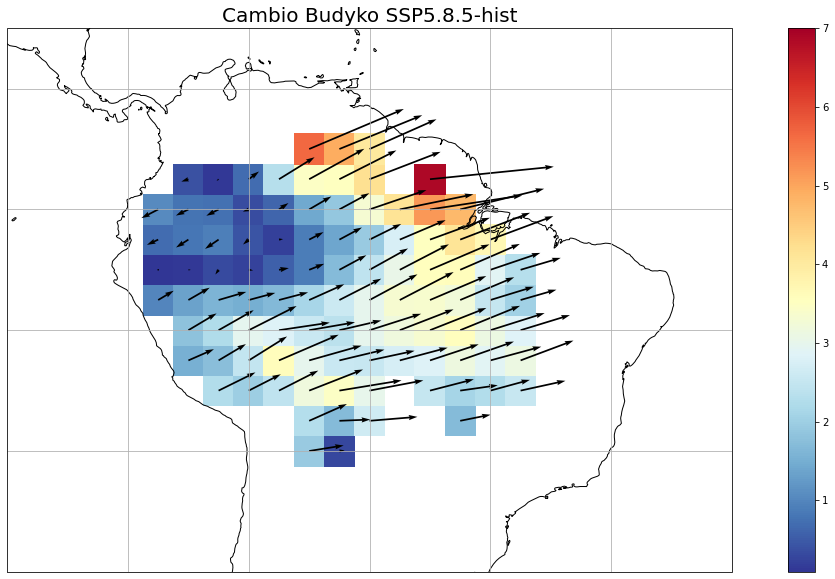

In [150]:
u = (ep_c6_585_far.mean(dim='time') / pr_c6_585_far.mean(dim='time')) - (
     ep_c6_ens.mean(dim='time') / pr_c6_ens.mean(dim='time'))

v = (ev_c6_585_far.mean(dim='time') / pr_c6_585_far.mean(dim='time')) - (
     ev_c6_ens.mean(dim='time') / pr_c6_ens.mean(dim='time'))

mod_change = np.sqrt((u*u)  + (v*v))

plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([270, 330, 15, -30], crs=ccrs.PlateCarree())
(mod_change * 10).where(amazon_mask == 1).plot(cmap='RdYlBu_r', vmax=7)
ax.coastlines()
ax.gridlines()
ax.quiver(u.lon.values, u.lat.values, u.where(amazon_mask == 1), v.where(amazon_mask == 1), scale=4)
plt.title('Cambio Budyko SSP5.8.5-hist', fontsize=20)
plt.show()